In [73]:
import ast
import os
import pickle as pkl
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchmetrics.functional.classification import (
    multilabel_average_precision,
)

plt.style.use("science")

**Load annotations and results**

In [74]:
# model name
model_name = "slow_r50-w-negatives"
folder_path = "../dataset/results/"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segements.txt"




# list all result files in the folder which end with .pkl and contain the model name
result_info = {}

for file in os.listdir(folder_path):
    if file.endswith(".pkl") and model_name in file:
        is_kinetics = False

        if "-kinetics" not in file:
            epoch = file.split("_")[-2].split("=")[1]
        else:
            epoch = file.split("_")[-2].split("=")[1].split("-")[0]

        # get the split from the file name
        split = file.split("=")[-1].split(".")[0]

        # add model to the dictionary
        if model_name not in result_info:
            result_info[model_name] = {}
        # add epoch to the dictionary
        if epoch not in result_info[model_name]:
            result_info[model_name][epoch] = {}
        if split not in result_info[model_name][epoch]:
            result_info[model_name][epoch][split] = {}
        result_info[model_name][epoch][split] = {
            "file_path": os.path.join(folder_path, file),
        }

In [75]:
metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

# build dict for behavioural where key is the segment and value is the behaviour is the same index
behavioural_dict = {}
for i, (b, s) in enumerate(zip(behaviours, segments)):
    if s not in behavioural_dict:
        behavioural_dict[s] = []
    behavioural_dict[s].append(b)


def read_files(model_results, epoch):
    with open(model_results[epoch]["train"]["file_path"], "rb") as f:
        train_data = pkl.load(f)

    with open(model_results[epoch]["val"]["file_path"], "rb") as f:
        val_data = pkl.load(f)

    return train_data, val_data


def results2df(train_data, val_data, metadata_df):
    # Process subclips
    subclips = []
    for i, split in enumerate([train_data, val_data]):
        for name, pred, feat, label in zip(
            split["names"], split["preds"], split["feats"], split["labels"]
        ):
            subclips.append(
                {
                    "name": name,
                    "split": i,
                    "pred": pred,
                    "feat": feat,
                    "negative": True if sum(label) == 0 else False,
                }
            )

    df = pd.DataFrame(subclips, columns=["name", "split", "pred", "feat", "negative"])

    df["split"] = df.split.map({0: "train", 1: "val"})
    df = df.merge(metadata_df, how="left", left_on="name", right_on="subject_id")

    # Apply sigmoid to predictions
    df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))

    # Convert label from str to int
    df.label = df.label.apply(lambda x: np.array(ast.literal_eval(x)))

    # Add negative
    df["negative"] = df.label.apply(lambda x: sum(x) == 0)

    # Add global location count to dataframe
    df["location_count"] = df.utm.map(df.utm.value_counts())

    # filter out negative samples from the dataframe
    #df = df[~df.negative]

    # Return train and val dataframes
    train_df = df[df.split == "train"]
    val_df = df[df.split == "val"]

    return train_df, val_df


def print_per_segement_performance(map, segment, show_per_class=True):
    res = []
    for i, (b, s) in enumerate(zip(map, segments)):
        if s == segment:
            res.append({behaviours[i]: b})
    agg_values = []
    for r in res:
        for _, value in r.items():
            agg_values.append(value)

    if show_per_class:
        return {
            segment: {
                "mean": np.round(np.mean(agg_values), 3),
                "values": res,
            }
        }
    else:
        return {
            segment: {
                "mean": np.round(np.mean(agg_values), 3),
            }
        }

{'few_shot': ['aggression', 'display', 'piloerection', 'playing'], 'tail': ['bipedal', 'camera_reaction', 'climbing', 'feeding', 'grooming', 'object_carrying', 'tool_use', 'vocalisation'], 'head': ['resting', 'travel']}


In [76]:
def calculate_metrics(df, round_to=3, show_per_class=False):
    map = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])),
        num_labels=14,
        average="none",
    )

    # replace -0.0 with 0.0
    map[map == -0.0] = 0.0

    map_head = print_per_segement_performance(map, "head", show_per_class)
    map_tail = print_per_segement_performance(map, "tail", show_per_class)
    map_fs = print_per_segement_performance(map, "few_shot", show_per_class)

    if show_per_class:
        map_head_values = map_head["head"]["values"]
        map_tail_values = map_tail["tail"]["values"]
        map_fs_values = map_fs["few_shot"]["values"]

    map_head = round(float(map_head["head"]["mean"]), round_to)
    map_tail = round(float(map_tail["tail"]["mean"]), round_to)
    map_fs = round(float(map_fs["few_shot"]["mean"]), round_to)

    avg_map = round(map.mean().item(), round_to)

    if show_per_class:
        for i in range(len(map_head_values)):
            for key, value in map_head_values[i].items():
                map_head_values[i][key] = round(value.item(), round_to)
        for i in range(len(map_tail_values)):
            for key, value in map_tail_values[i].items():
                map_tail_values[i][key] = round(value.item(), round_to)

        for i in range(len(map_fs_values)):
            for key, value in map_fs_values[i].items():
                map_fs_values[i][key] = round(value.item(), round_to)

        return (
            avg_map,
            map_head,
            map_head_values,
            map_tail,
            map_tail_values,
            map_fs,
            map_fs_values,
        )

    return avg_map, map_head, map_tail, map_fs

In [77]:
def return_ct_location_segments(df, head=50, tail=10):
    """
    Returns the location segments based on the given dataframe and thresholds.

    Args:
        df (pandas.DataFrame): The input dataframe containing the location data.
        head (int, optional): The threshold percentage for selecting locations that make up the top percentage of data. Defaults to 50.
        tail (int, optional): The threshold count for selecting locations outside the top percentage with more than this count. Defaults to 10.

    Returns:
        tuple: A tuple containing three dataframes:
            - head_locations: Dataframe containing the top locations and their video counts.
            - tail_locations: Dataframe containing the locations outside the top percentage with more than the tail count.
            - few_shot_locations: Dataframe containing the locations with fewer than the tail count.
    """
    # Group by 'utm' and count the number of videos for each location
    location_counts = train_df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Select locations that make up 50% of the data
    head_locations = location_counts[location_counts["cumulative_percentage"] <= head]

    # Calculate locations outside the top 50% with more than 10 samples
    tail_locations = location_counts[location_counts["cumulative_percentage"] > head]
    tail_locations = tail_locations[tail_locations["video_count"] > tail]

    # Calculate locations with fewer than 10 samples
    few_shot_locations = location_counts[location_counts["video_count"] < tail]

    return (
        head_locations[["utm", "video_count"]],
        tail_locations[["utm", "video_count"]],
        few_shot_locations[["utm", "video_count"]],
    )



def plot_camera_locations_distribution(df, head=50, tail=10, use_proportion=False):
    # Group by 'utm' and count the number of videos for each location
    location_counts = df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative sum and percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Identify the indices for head (50%), tail (>10), and few-shot (<10) segments
    head_index = location_counts[
        location_counts["cumulative_percentage"] <= head
    ].index[-1]
    tail_index = location_counts[location_counts["video_count"] > tail].index[-1]

    # Determine y-axis values based on use_proportion
    y_values = (
        location_counts["cumulative_percentage"]
        if use_proportion
        else location_counts["cumulative_count"]
    )
    y_label = (
        "Cumulative Proportion of Videos"
        if use_proportion
        else "Cumulative Number of Videos"
    )
    y_max = 100 if use_proportion else total_videos

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(location_counts)), y_values, "b-")

    # Add vertical lines and annotations for segments
    plt.axvline(x=head_index, color="r", linestyle="--", label="Head (50%)")
    plt.axvline(x=tail_index, color="g", linestyle="--", label="Tail (>10 samples)")

    # Fill areas for each segment
    plt.fill_between(
        range(head_index + 1),
        y_values[: head_index + 1],
        alpha=0.3,
        color="r",
        label="Head",
    )
    plt.fill_between(
        range(head_index + 1, tail_index + 1),
        y_values[head_index + 1 : tail_index + 1],
        alpha=0.3,
        color="g",
        label="Tail",
    )
    plt.fill_between(
        range(tail_index + 1, len(location_counts)),
        y_values[tail_index + 1 :],
        alpha=0.3,
        color="y",
        label="Few-shot",
    )

    # Customize the plot
    plt.title("Cumulative Distribution of Videos Across Camera Locations")
    plt.xlabel("Camera Locations (sorted by video count)")
    plt.ylabel(y_label)
    plt.legend()

    # Add text annotations
    plt.text(
        head_index,
        y_max / 2,
        f"Head: {head_index+1} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        tail_index,
        y_max / 2,
        f"Tail: {tail_index-head_index} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        len(location_counts) - 1,
        y_max / 2,
        f"Few-shot: {len(location_counts)-tail_index-1} locations",
        rotation=90,
        verticalalignment="center",
    )

    plt.ylim(0, y_max)
    plt.show()

In [78]:
# Helper function to process and merge segments
def process_and_merge(df, segments, head=50, tail=10):
    h_df, t_df, f_df = return_ct_location_segments(df, head=head, tail=tail)
    segments["h"] = h_df.merge(df, on="utm", how="left").dropna()
    segments["t"] = t_df.merge(df, on="utm", how="left").dropna()
    segments["f"] = f_df.merge(df, on="utm", how="left").dropna()
    return segments


def calculate_all_metrics(segments, show_per_class=False):
    metrics = {}
    for key in ["h", "t", "f"]:
        (
            metrics[f"avg_map_{key}"],
            metrics[f"map_{key}_head"],
            metrics[f"map_{key}_head_values"],
            metrics[f"map_{key}_tail"],
            metrics[f"map_{key}_tail_values"],
            metrics[f"map_{key}_fs"],
            metrics[f"map_{key}_fs_values"],
        ) = calculate_metrics(df=segments[f"{key}"], show_per_class=show_per_class)
    return metrics


def plot_heatmap(data, title, ax, labels, behaviors=None):
    cax = ax.imshow(data, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=8, rotation=45, ha="right", rotation_mode="anchor")
    if behaviors is not None:
        ax.set_yticks(np.arange(len(behaviors)))
        ax.set_yticklabels(behaviors, fontsize=8)
    else:
        ax.set_yticks(np.arange(data.shape[0]))
        ax.set_yticklabels(labels, fontsize=8)


    if behaviors is None:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, f"{data[i, j]:.3f}", ha="center", va="center")
    else:
        for i in range(len(behaviors)):
            for j in range(len(labels)):
                if behaviors[i] in behavioural_dict["head"]:
                    ax.text(
                        j,
                        i,
                        f"{data[i, j]:.2f}",
                        ha="center",
                        va="center",
                        color="lime",
                    )
                elif behaviors[i] in behavioural_dict["tail"]:
                    ax.text(
                        j,
                        i,
                        f"{data[i, j]:.2f}",
                        ha="center",
                        va="center",
                        color="magenta",
                    )
                elif behaviors[i] in behavioural_dict["few_shot"]:
                    ax.text(
                        j,
                        i,
                        f"{data[i, j]:.2f}",
                        ha="center",
                        va="center",
                        color="olive",
                    )

    ax.set_xlabel("Camera locations", fontsize=8)
    ax.set_ylabel("Behaviors", fontsize=8)

    # add legend for behaviors colors below the heatmap

    ax.set_title(title, fontsize=10)
    if behaviors is not None:
        # add legend for behaviors colors below the heatmap
        ax.legend(
            [
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="lime"),
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="magenta"),
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="olive"),
            ],
            [
                "Head",
                "Tail",
                "Few-shot",
            ],
            loc="upper center",
            bbox_to_anchor=(0.5, -0.1),
            ncol=3,
            fontsize=8,
        )

    plt.tight_layout()

In [79]:
result_info

{'slow_r50-w-negatives': {'100': {'val': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=100_split=val.pkl'},
   'train': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=100_split=train.pkl'}},
  '200': {'train': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=200_split=train.pkl'},
   'val': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=200_split=val.pkl'}},
  '0': {'train': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=0-kinetics_split=train.pkl'},
   'val': {'file_path': '../dataset/results/model=slow_r50-w-negatives_e=0-kinetics_split=val.pkl'}}}}

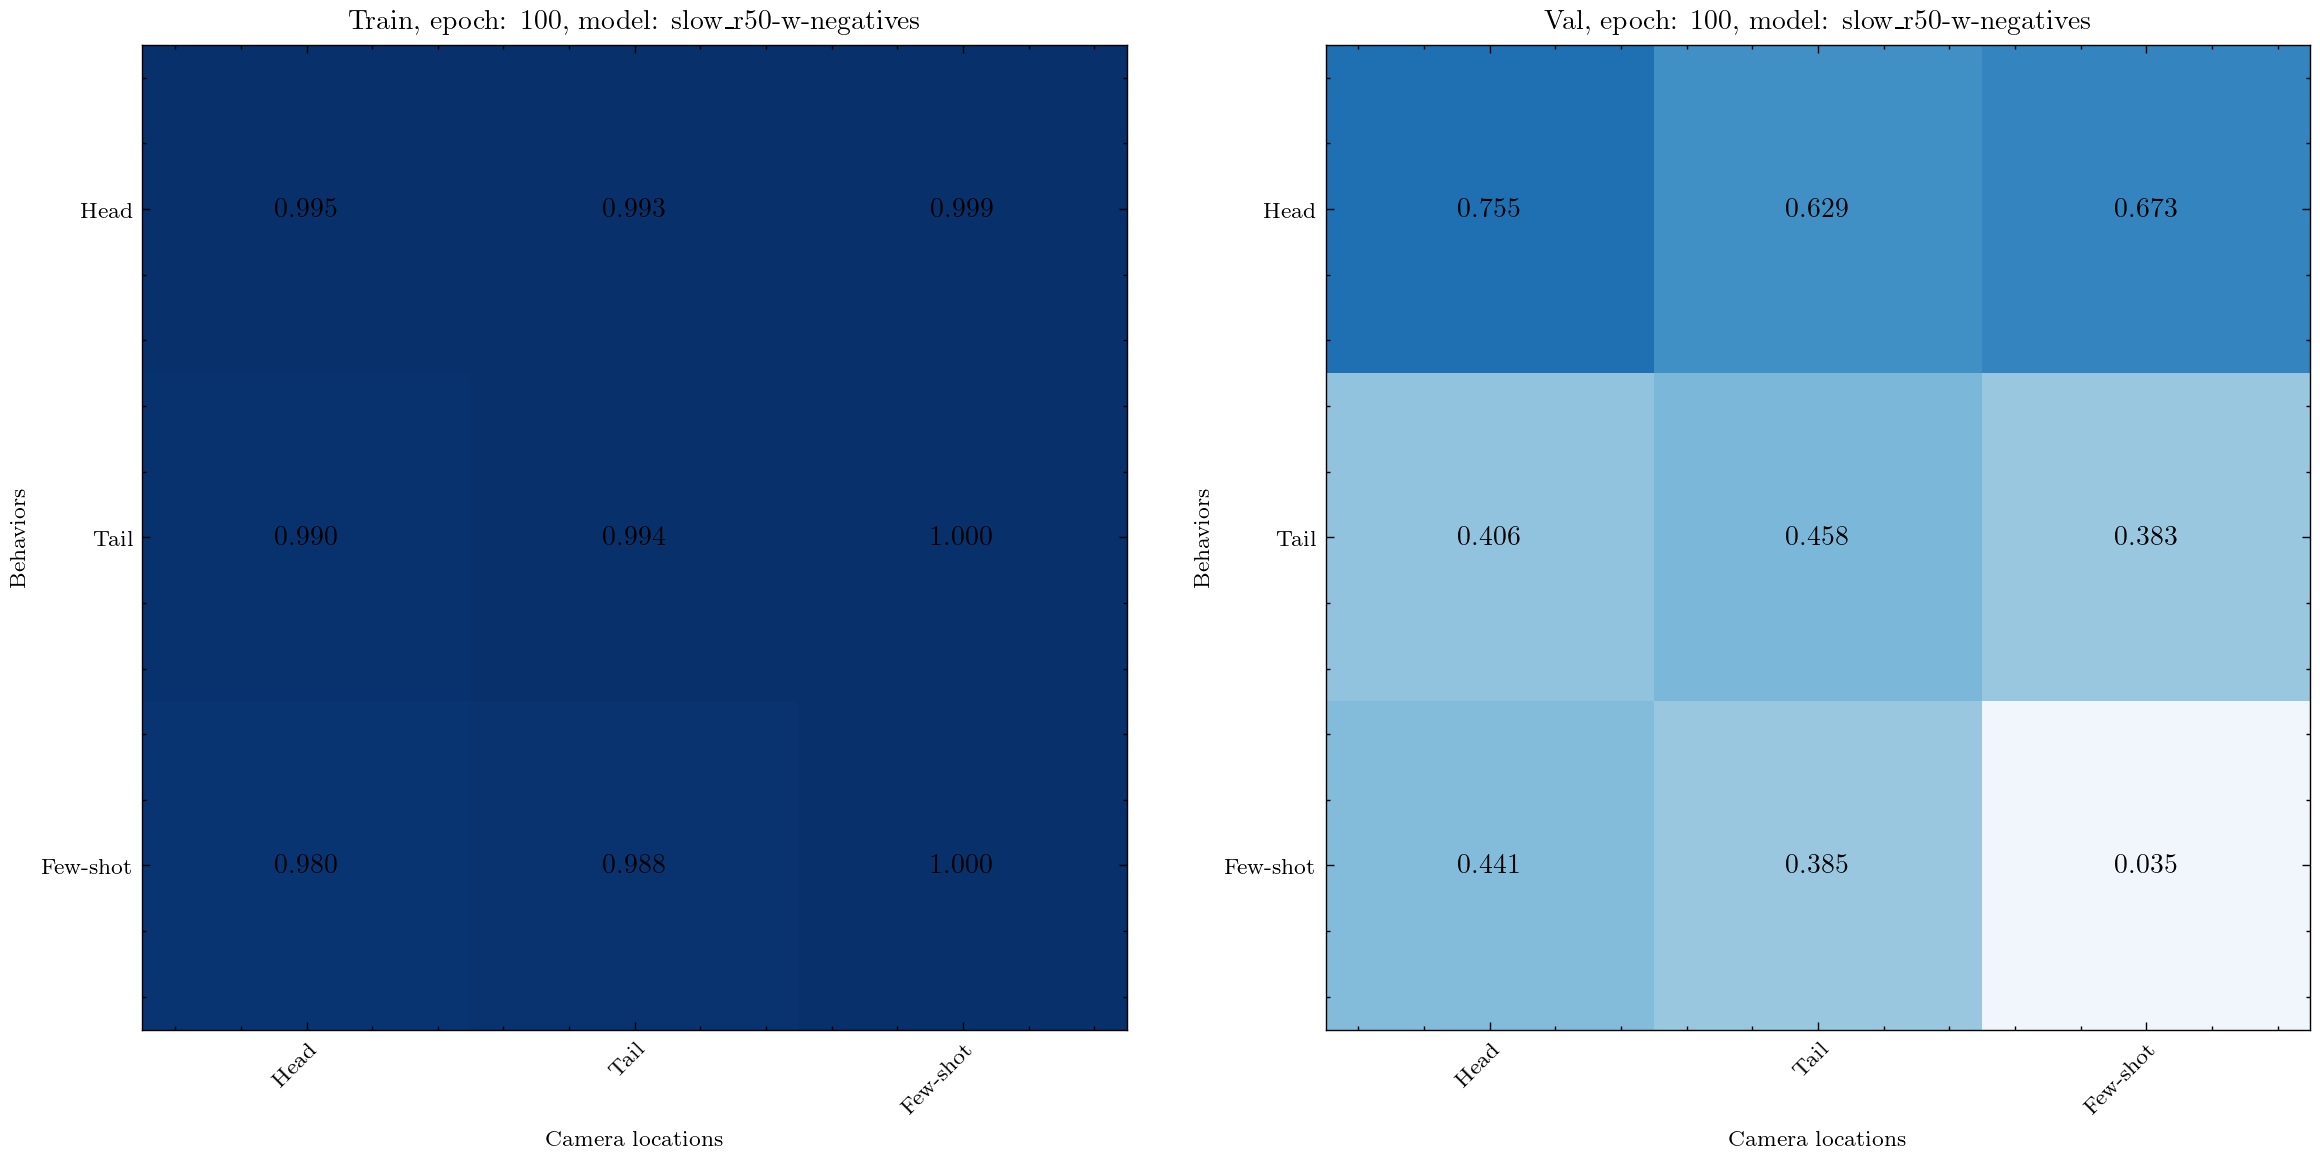

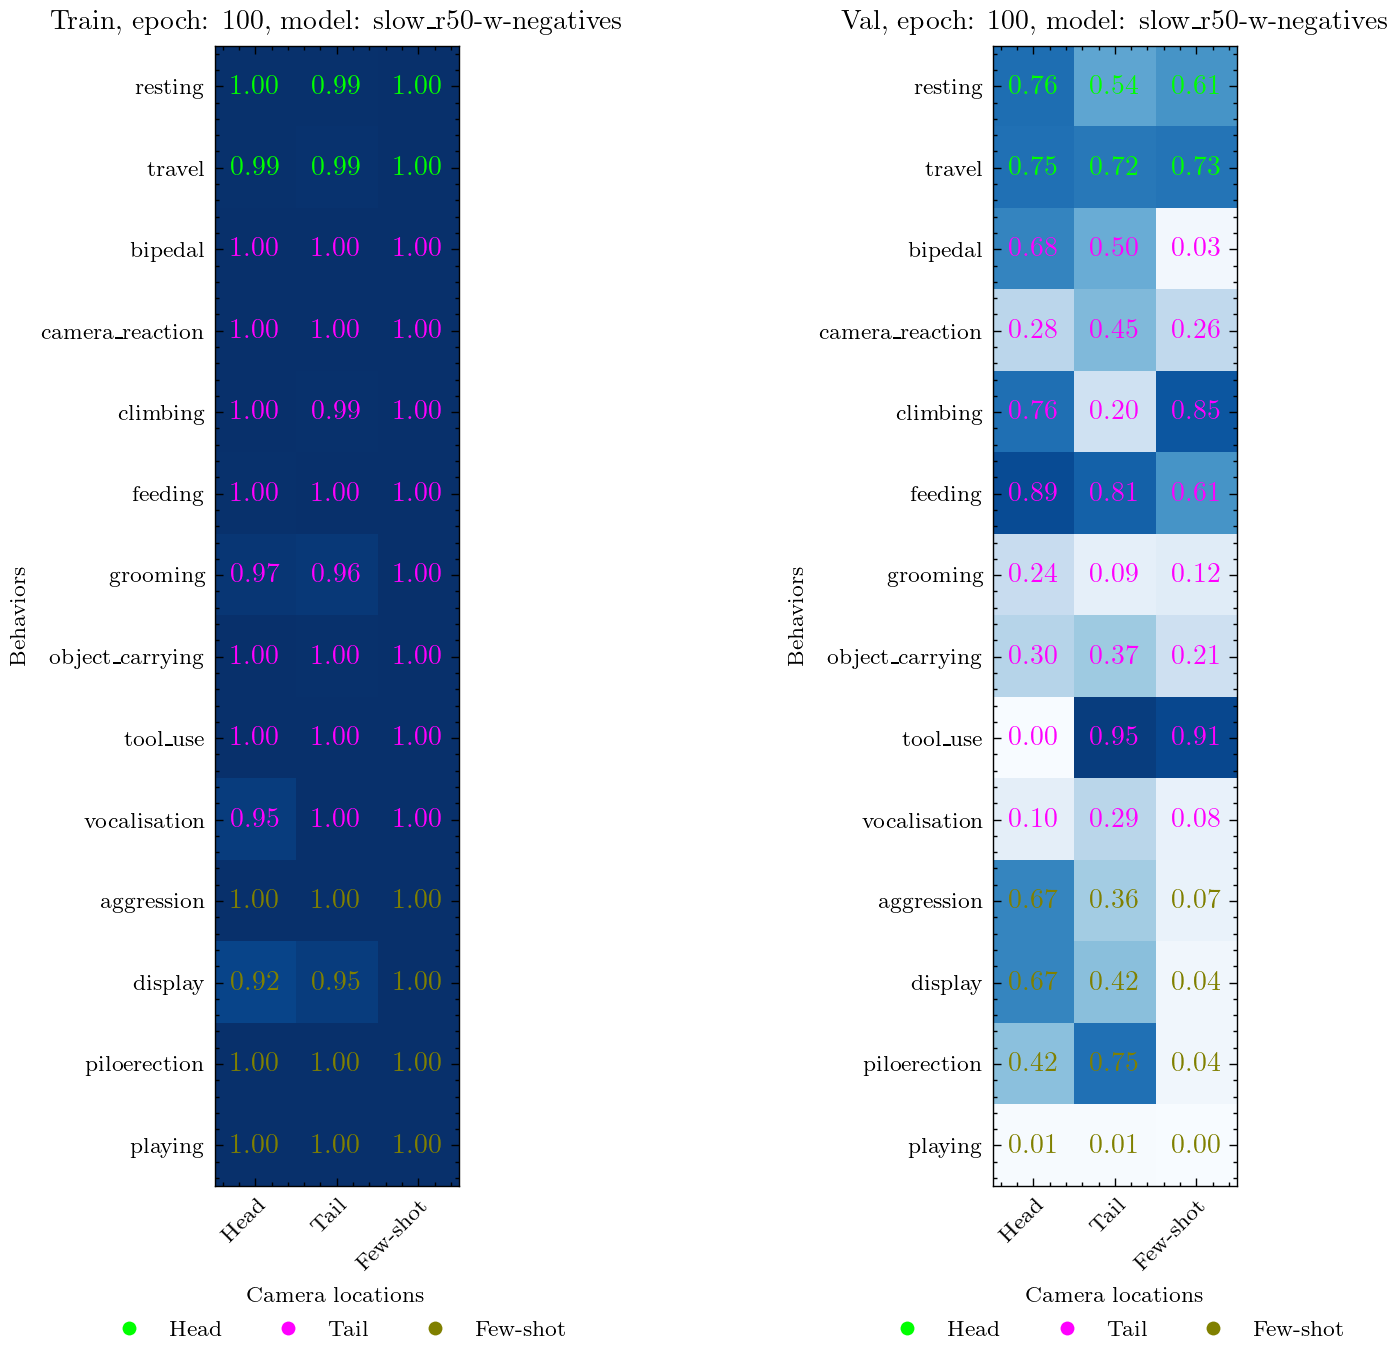

/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


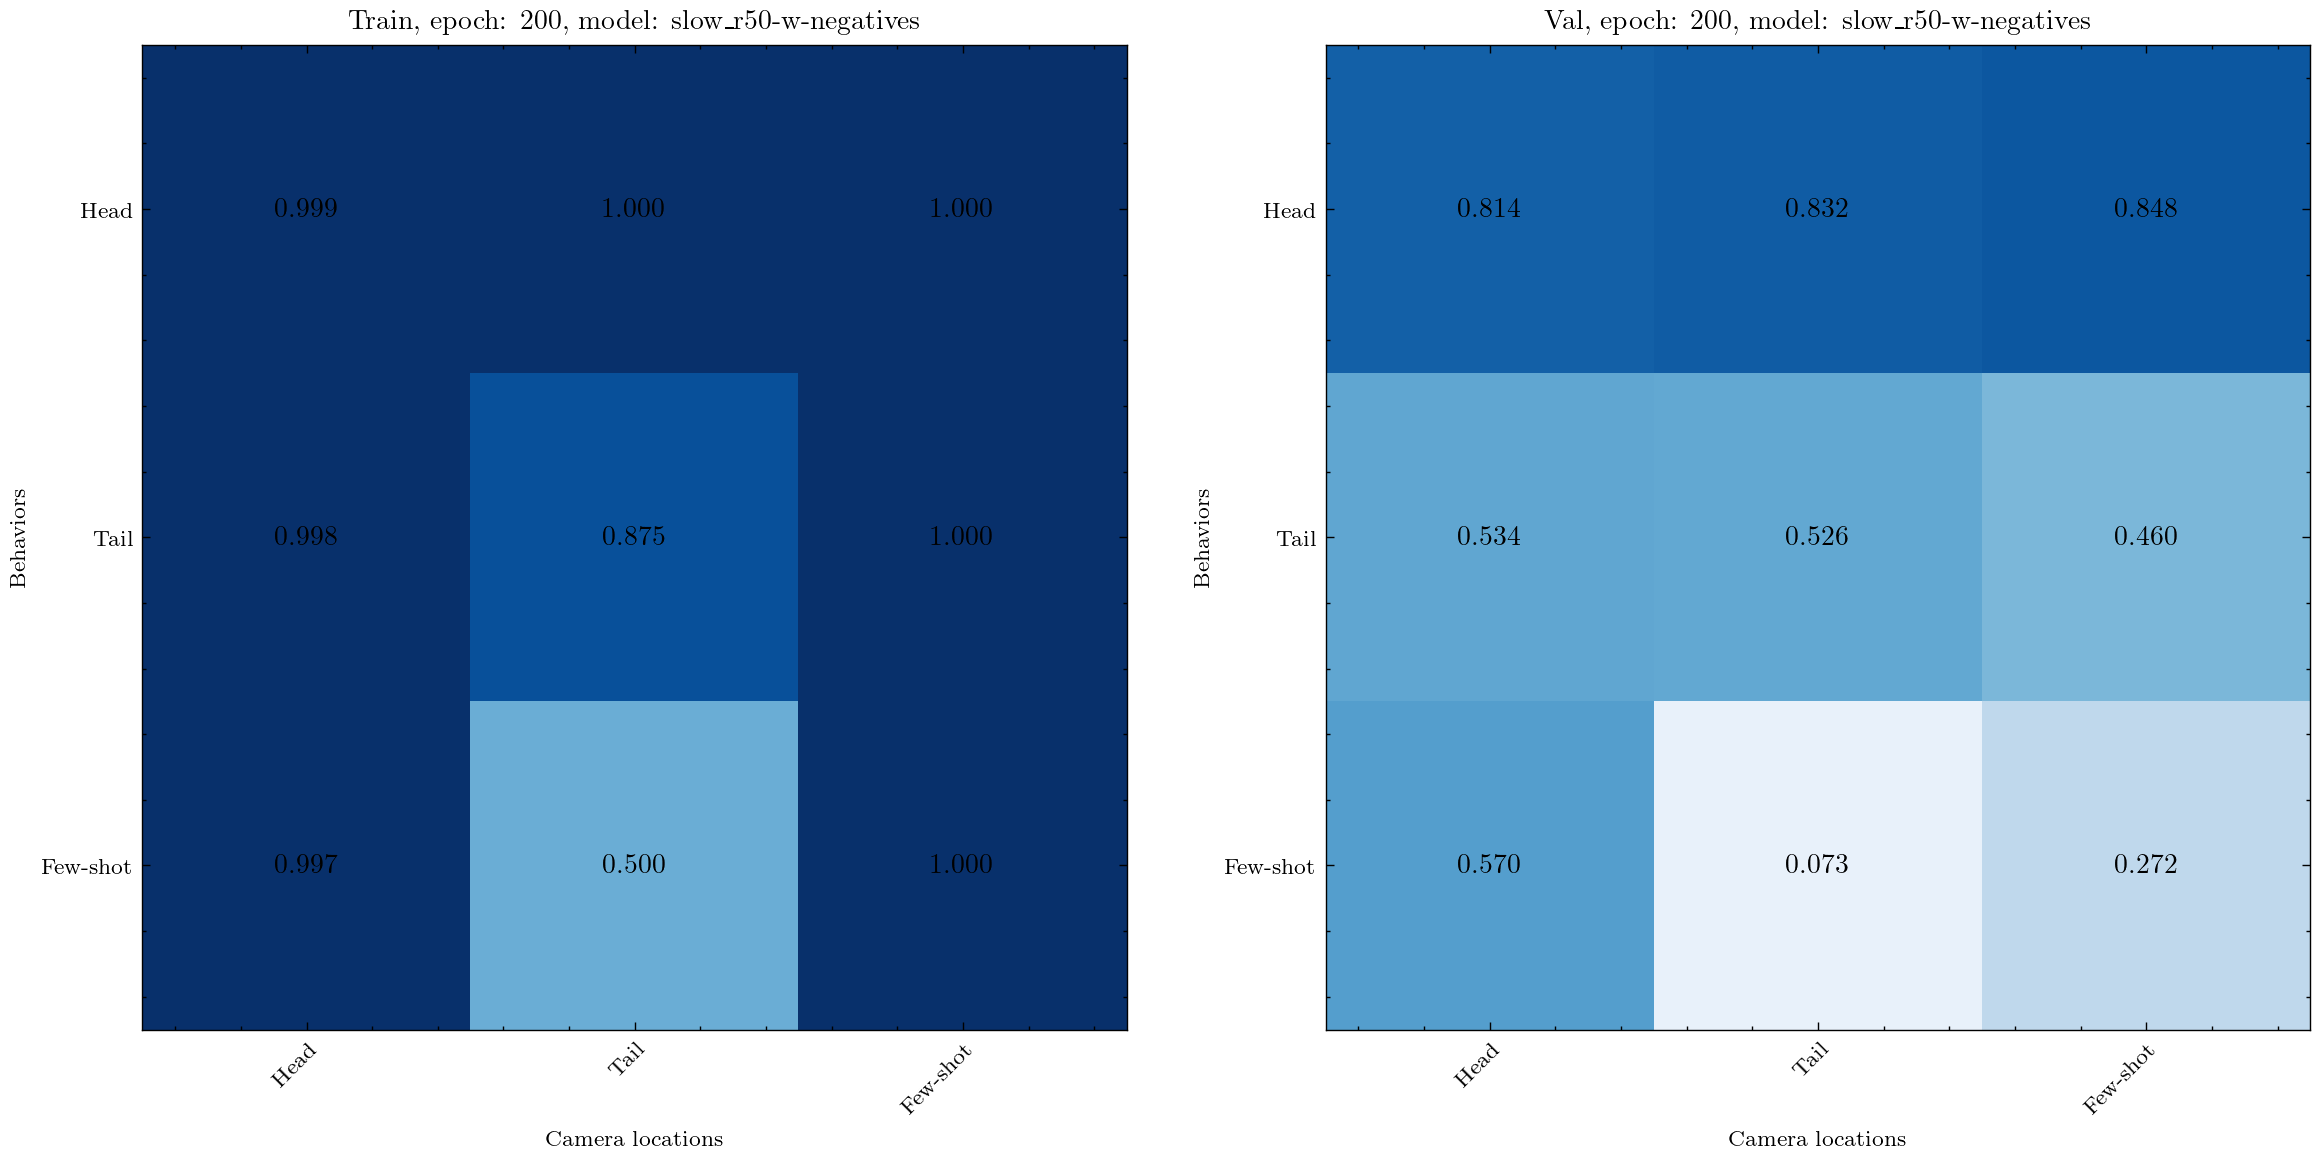

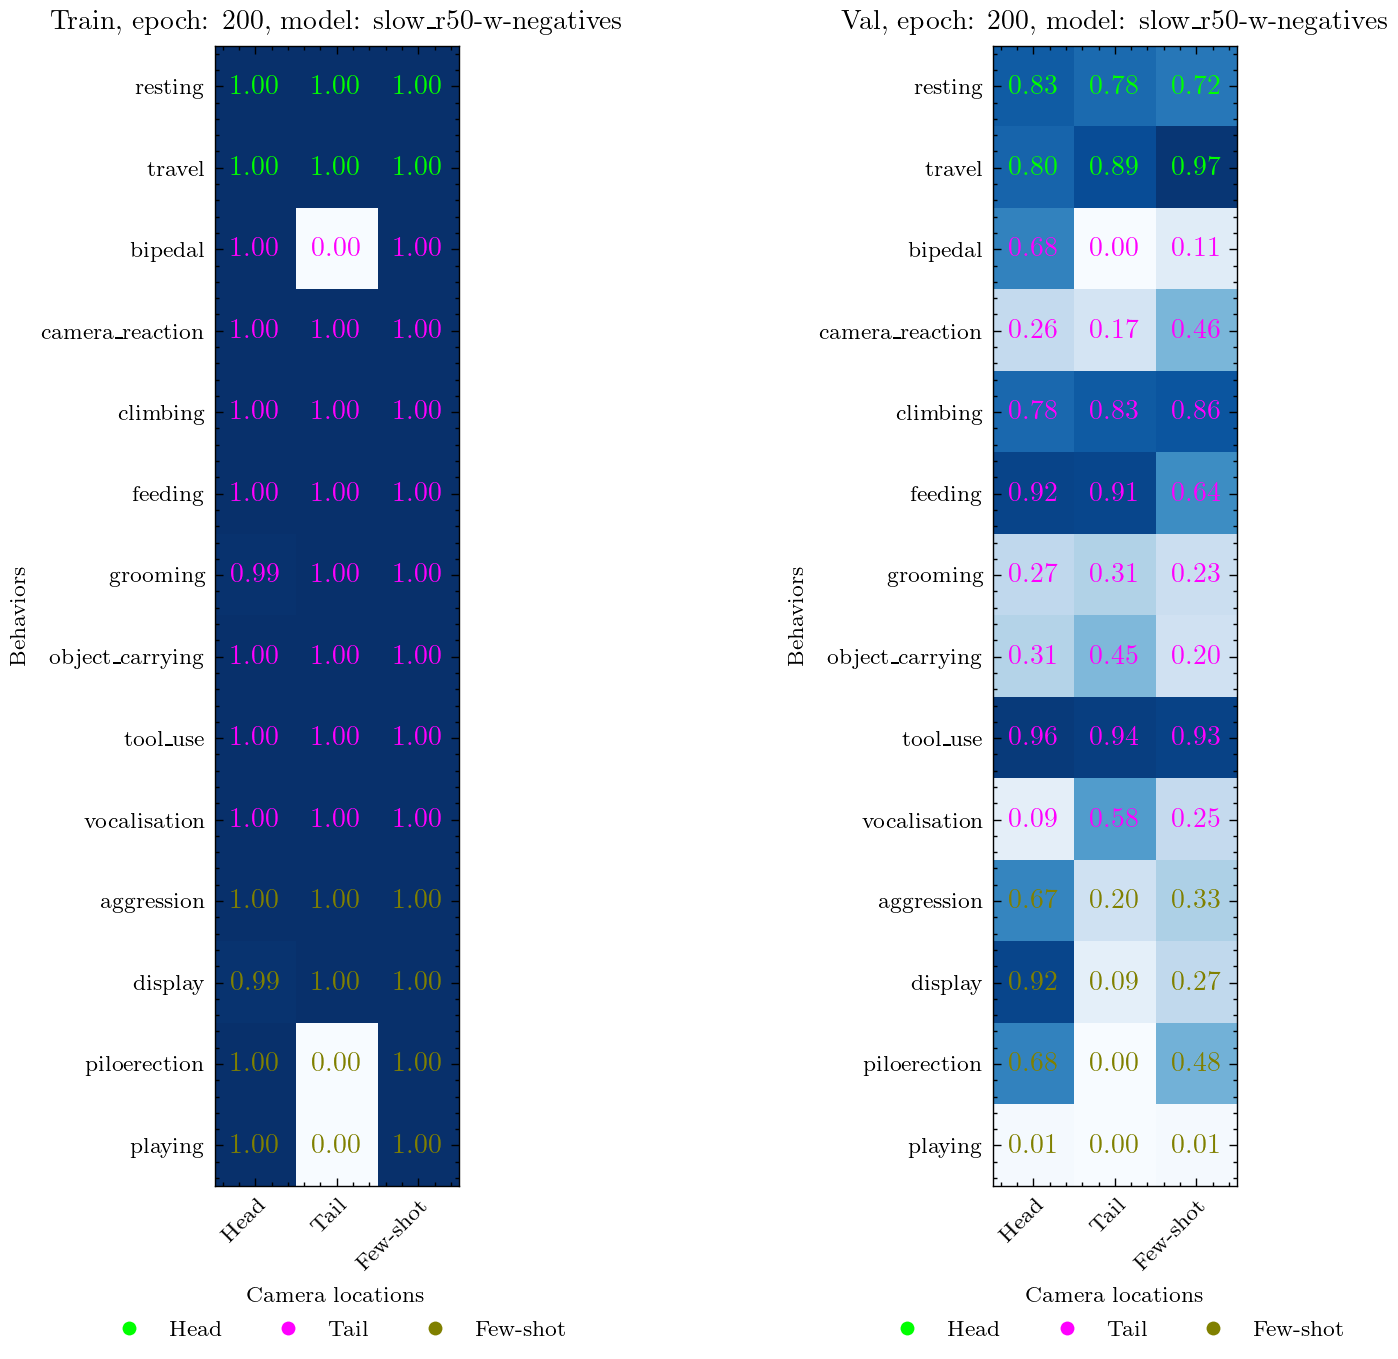

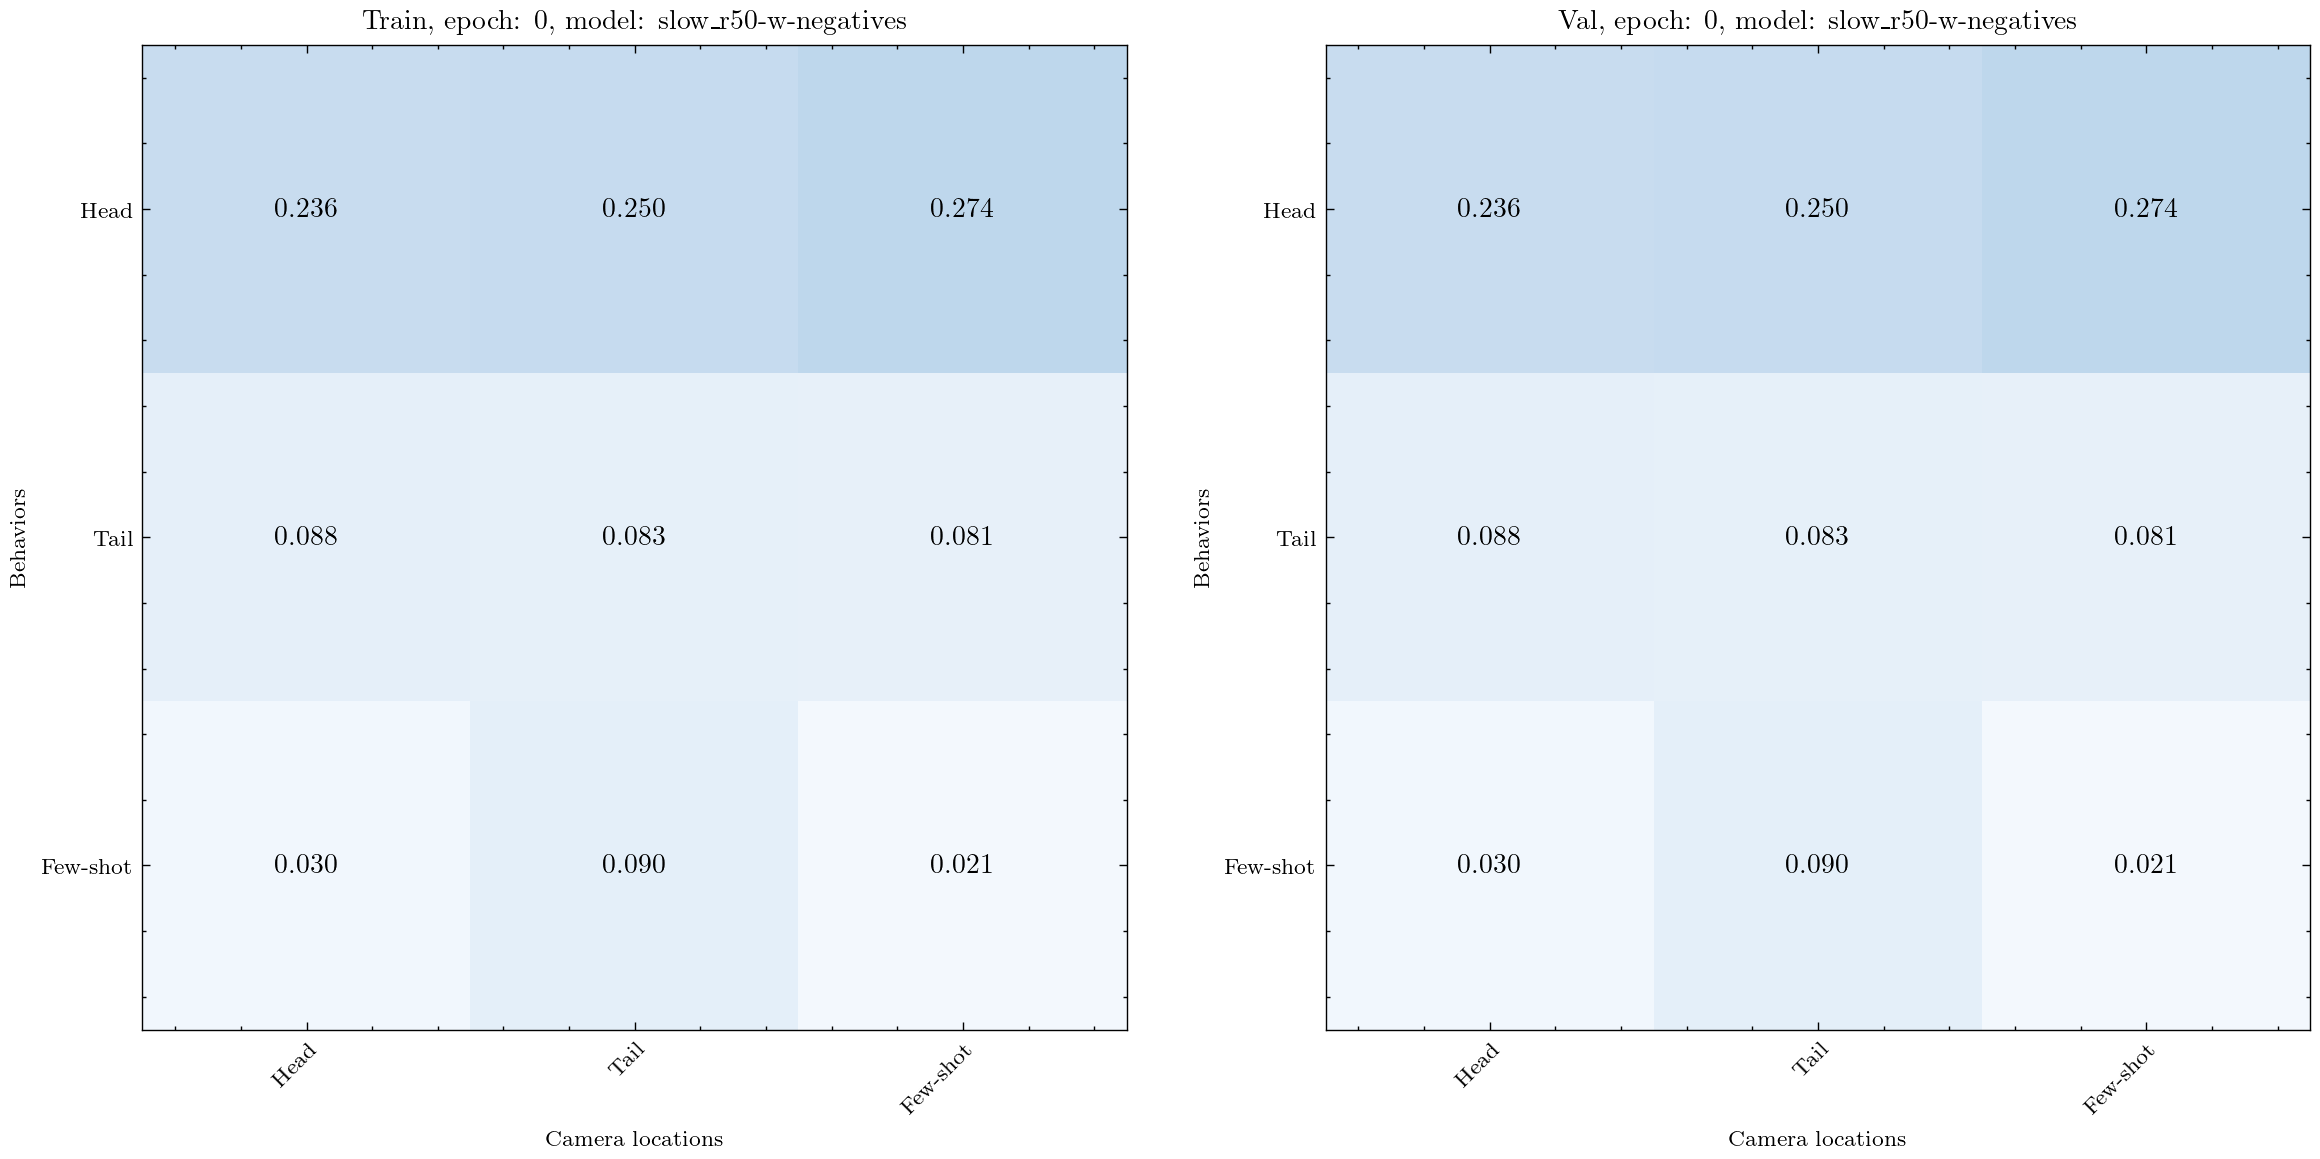

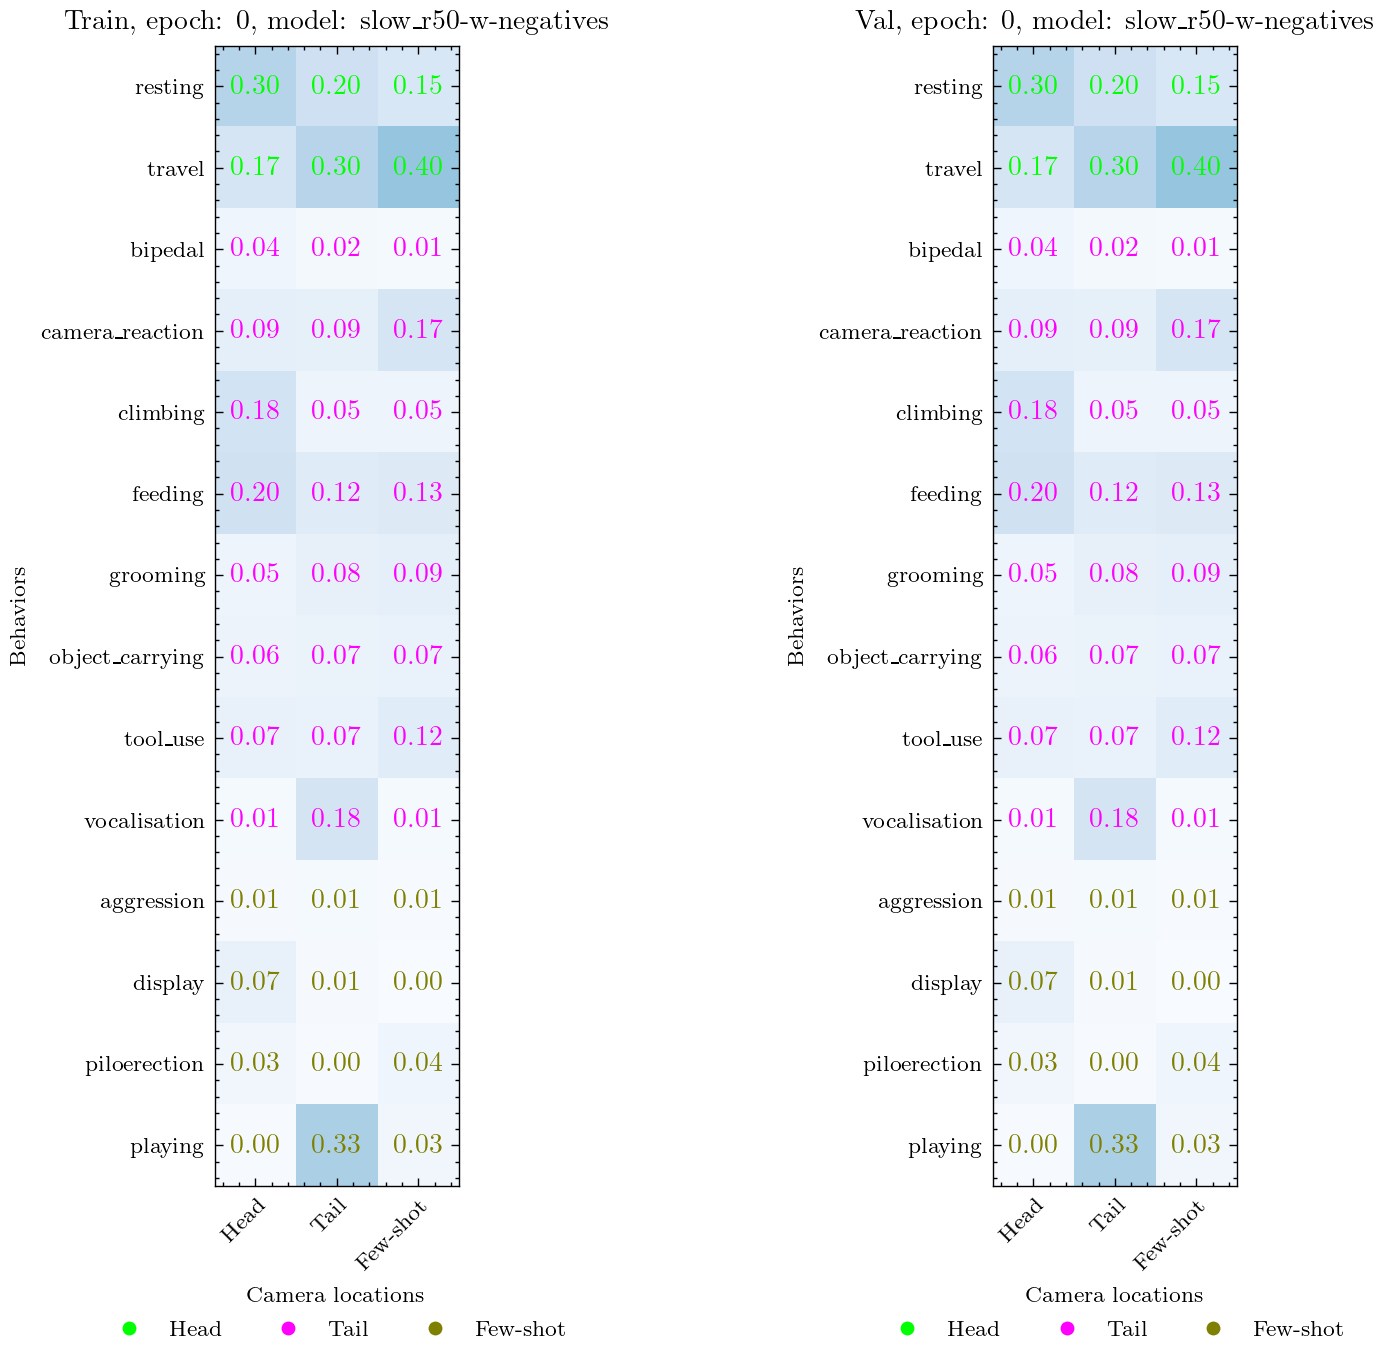

In [80]:
labels = ["Head", "Tail", "Few-shot"]
reordered_behaviours = [
    "resting",
    "travel",
    "bipedal",
    "camera_reaction",
    "climbing",
    "feeding",
    "grooming",
    "object_carrying",
    "tool_use",
    "vocalisation",
    "aggression",
    "display",
    "piloerection",
    "playing",
]


# Merge behavior data into final_train_data
# "h", "t", "f" are the segments of camera locations
# "head", "tail", "few_shot" are the segments of behaviors
# so if we have a key "map_h_head_values" it means that the values are for the head segment of the camera locations and the head segment of the behaviors
# Here we aggregate the values of the behaviors for each segment of the camera locations
key_map = {
    "map_h_head_values": "head",
    "map_h_tail_values": "head",
    "map_h_fs_values": "head",
    "map_t_head_values": "tail",
    "map_t_tail_values": "tail",
    "map_t_fs_values": "tail",
    "map_f_head_values": "few_shot",
    "map_f_tail_values": "few_shot",
    "map_f_fs_values": "few_shot",
}


for m in result_info:
    for epoch in result_info[m]:
        train_data, val_data = read_files(result_info[model_name], epoch)
        train_df, val_df = results2df(train_data, val_data, metadata_df)

        train_segments = {}
        val_segments = {}

        train_segments = process_and_merge(train_df, train_segments)
        val_segments = process_and_merge(val_df, val_segments)

        train_metrics = calculate_all_metrics(train_segments, show_per_class=True)

        val_metrics = calculate_all_metrics(val_segments, show_per_class=True)

        train_data = np.array(
            [
                [
                    train_metrics["map_h_head"],
                    train_metrics["map_h_tail"],
                    train_metrics["map_h_fs"],
                ],
                [
                    train_metrics["map_t_head"],
                    train_metrics["map_t_tail"],
                    train_metrics["map_t_fs"],
                ],
                [
                    train_metrics["map_f_head"],
                    train_metrics["map_f_tail"],
                    train_metrics["map_f_fs"],
                ],
            ]
        )

        val_data = np.array(
            [
                [
                    val_metrics["map_h_head"],
                    val_metrics["map_h_tail"],
                    val_metrics["map_h_fs"],
                ],
                [
                    val_metrics["map_t_head"],
                    val_metrics["map_t_tail"],
                    val_metrics["map_t_fs"],
                ],
                [
                    val_metrics["map_f_head"],
                    val_metrics["map_f_tail"],
                    val_metrics["map_f_fs"],
                ],
            ]
        )

        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False, dpi=200)
        plot_heatmap(
            train_data.T, f"Train, epoch: {epoch}, model: {model_name}", ax[0], labels
        )

        plot_heatmap(
            val_data.T,
            f"Val, epoch: {epoch}, model: {model_name}",
            ax[1],
            labels,
        )
        # save as png
        fig.savefig(
            f"../figures/heatmap_{model_name}_epoch_{epoch}.png",
            dpi=200,
            bbox_inches="tight",
        )
        plt.show()

        # plot for each behaviour the performance for head, tail and few-shot segments

        # Extract and merge behavior data
        train_behaviour_data = defaultdict(dict)
        val_behaviour_data = defaultdict(dict)

        for key in key_map.keys():
            v = [list(d.values())[0] for d in train_metrics[key]]
            k = [list(d.keys())[0] for d in train_metrics[key]]
            # print(f"train mAP {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                train_behaviour_data[key][k[i]] = value

            v = [list(d.values())[0] for d in val_metrics[key]]
            k = [list(d.keys())[0] for d in val_metrics[key]]
            # print(f"val mAP for {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                val_behaviour_data[key][k[i]] = value

        # Initialize final_train_data with keys head, tail, few_shot
        final_train_data = {seg: {} for seg in set(list(key_map.values()))}
        final_val_data = {seg: {} for seg in set(list(key_map.values()))}

        for k, v in train_behaviour_data.items():
            if k in key_map:
                final_train_data[key_map[k]].update(v)

        for k, v in val_behaviour_data.items():
            if k in key_map:
                final_val_data[key_map[k]].update(v)

        # Prepare data matrix
        train_data_matrix = np.array(
            [
                [final_train_data["head"][beh] for beh in reordered_behaviours],
                [final_train_data["tail"][beh] for beh in reordered_behaviours],
                [final_train_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T
        val_data_matrix = np.array(
            [
                [final_val_data["head"][beh] for beh in reordered_behaviours],
                [final_val_data["tail"][beh] for beh in reordered_behaviours],
                [final_val_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T

        # Plot heatmap
        fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=False, dpi=200)
        plot_heatmap(
            train_data_matrix,
            f"Train, epoch: {epoch}, model: {model_name}",
            ax[0],
            labels,
            reordered_behaviours,
        )
        plot_heatmap(
            val_data_matrix,
            f"Val, epoch: {epoch}, model: {model_name}",
            ax[1],
            labels,
            reordered_behaviours,
        )

        plt.show()

        fig.savefig(
            f"../figures/heatmap_{model_name}_epoch_{epoch}_behaviorswise.png",
            dpi=200,
            bbox_inches="tight",
        )